# Simulation For Sporadic Traffic

In [1]:
import numpy as np
import scipy.special as sp
import torch
from tqdm import tqdm_notebook
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import torch.nn as nn
from utils import *
from DLutils import *

Hyper Parameters

In [2]:
params = {
    'K': 500, # number of potential users
    'Ka': 50, # number of active users
    'N_bs': 64, # number of receiver antennas
    'N_ms': 1, # number of user antennas
    'fc': 2e9, # frequency of carrier
    'sigma2alpha': 1, # average power of path
    'Bw': 1e7, # bandwidth
    'fs': 1e7, # frequency of sampling
    'N': 2048, # number of carriers
    'P': 1, # length of pilot
    'Lp_min': 8, # min number of pathes
    'Lp_max': 14, # max number of pathes
    'snr': 20, # SNR in dB
    'simulations': 300, # total simulation numbers
    'T_set': np.arange(30, 82, 2), # choices for time overhead
    'Ka_set': np.arange(30, 155, 5), # choices for number of active users
    'LR': 0.0001, # learning rate
    'EPOCH': 400, # training epochs
    'T': 50, # time overhead
}
delta_p = np.floor(params['N'] / params['P']).astype(int)
P_set = np.linspace(delta_p, params['P'] * delta_p, params['P'])
params.update({'P_set':  P_set})
nvar = 10 ** (-params['snr'] / 10)
params.update({'nvar': nvar})

In [65]:
Pe_p = np.zeros(params['T_set'].shape)
FA_p = np.zeros(params['T_set'].shape)
FM_p = np.zeros(params['T_set'].shape)
NMSE = np.zeros(params['T_set'].shape)
Pe_h = np.zeros(params['T_set'].shape)
FA_h = np.zeros(params['T_set'].shape)
FM_h = np.zeros(params['T_set'].shape)
for i, T in enumerate(params['T_set']):
    H_f, H_a, activity = generate_batched_active_channel(params)
    pilot = generate_random_pilot(T, params['K'], params['P'], params['simulations'])
    y = pilot_through_channel(pilot, H_f, params['nvar'])
    
    xhat, lamda, iteration, NMSE_watch = dmmv_amp_detection(y, pilot)
    
    act_lam = lamda_aud(lamda, params['N_bs'])
    act_ch = channel_aud(xhat, params['N_bs'])
    Pe_p[i], FA_p[i], FM_p[i], NMSE[i] = performance(act_lam, activity, xhat, H_f)
    Pe_h[i], FA_h[i], FM_h[i], _ = performance(act_ch, activity, xhat, H_f)


C:\Users\Cbx\Anaconda3\envs\EE369\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


In [3]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

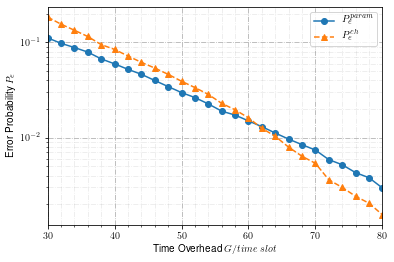

In [69]:
plt.semilogy(params['T_set'], Pe_p, '-o')
plt.semilogy(params['T_set'], Pe_h, '--^')
plt.xlim([30, 80])
plt.grid(True, linestyle='-.')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-.', alpha=0.2)
plt.legend(['$P_e^{param}$', '$P_e^{ch}$'])
plt.xlabel('Time Overhead $G/time\ slot$')
plt.ylabel('Error Probability $P_e$')
plt.savefig(fname='Probability_of_errorKa100.pdf')
plt.show()

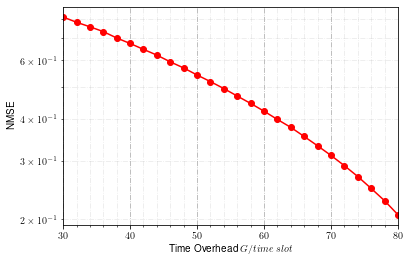

In [67]:
plt.semilogy(params['T_set'], NMSE, 'r-o')
plt.xlim([30, 80])
plt.grid(which='major', linestyle='-.')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-.', alpha=0.2)
plt.xlabel('Time Overhead $G/time\ slot$')
plt.ylabel('NMSE')
plt.savefig(fname='NMSEKa100.pdf')
plt.show()

In [68]:
np.savez('K500Ka100NBS64SNR20sim300AMP.npz', Pe_p, FM_p, FA_p, Pe_h, FM_h, FA_h, NMSE)

In [71]:
Pe_p = np.zeros(params['Ka_set'].shape)
FA_p = np.zeros(params['Ka_set'].shape)
FM_p = np.zeros(params['Ka_set'].shape)
NMSE = np.zeros(params['Ka_set'].shape)
Pe_h = np.zeros(params['Ka_set'].shape)
FA_h = np.zeros(params['Ka_set'].shape)
FM_h = np.zeros(params['Ka_set'].shape)
for i, Ka in enumerate(params['Ka_set']):
    params['Ka'] = Ka
    H_f, H_a, activity = generate_batched_active_channel(params)
    pilot = generate_random_pilot(50, params['K'], params['P'], params['simulations'])
    y = pilot_through_channel(pilot, H_f, params['nvar'])
    
    xhat, lamda, iteration, NMSE_watch = dmmv_amp_detection(y, pilot)
    
    act_lam = lamda_aud(lamda, params['N_bs'])
    act_ch = channel_aud(xhat, params['N_bs'])
    Pe_p[i], FA_p[i], FM_p[i], NMSE[i] = performance(act_lam, activity, xhat, H_f)
    Pe_h[i], FA_h[i], FM_h[i], _ = performance(act_ch, activity, xhat, H_f)

C:\Users\Cbx\Anaconda3\envs\EE369\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


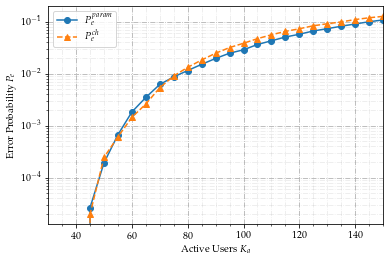

In [84]:
plt.semilogy(params['Ka_set'], Pe_p, '-o')
plt.semilogy(params['Ka_set'], Pe_h, '--^')
plt.xlim([30, 150])
plt.grid(True, linestyle='-.')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-.', alpha=0.2)
plt.legend(['$P_e^{param}$', '$P_e^{ch}$'])
plt.xlabel('Active Users $K_a$')
plt.ylabel('Error Probability $P_e$')
plt.savefig(fname='Probability_of_errorT50.pdf')
plt.show()

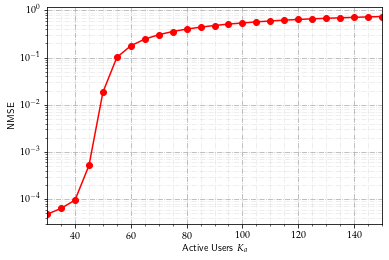

In [81]:
plt.semilogy(params['Ka_set'], NMSE, 'r-o')
plt.xlim([30, 150])
plt.grid(which='major', linestyle='-.')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-.', alpha=0.2)
plt.xlabel('Active Users $K_a$')
plt.ylabel('NMSE')
plt.savefig(fname='NMSET50.pdf')
plt.show()

In [79]:
np.savez('K500T50NBS64SNR20sim300AMP.npz', Pe_p, FM_p, FA_p, Pe_h, FM_h, FA_h, NMSE)

In [23]:
class ActNet(nn.Module):
    def __init__(self, N_bs, K, T):
        super(ActNet, self).__init__()
        self.K = K
        self.N_bs = N_bs
        self.T = T
        self.pilot_real = nn.Parameter(torch.FloatTensor(K, T))
        self.pilot_imag = nn.Parameter(torch.FloatTensor(K, T))
        self.decoder = nn.Sequential(
            nn.Linear(2 * T * N_bs, 2 * T * N_bs),
            nn.BatchNorm1d(2 * T * N_bs),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(2 * T * N_bs, 2 * T * N_bs),
            nn.BatchNorm1d(2 * T * N_bs),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(2 * T * N_bs, 2 * T * N_bs),
            nn.BatchNorm1d(2 * T * N_bs),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(2 * T * N_bs, K),
            nn.Sigmoid(),
        )
        nn.init.orthogonal_(self.pilot_real)
        nn.init.orthogonal_(self.pilot_imag)
        
    def forward(self, channel_real, channel_imag, nvar):
        noise_real = (np.sqrt(nvar / 2) * torch.randn(self.N_bs, self.T)).cuda()
        noise_imag = (np.sqrt(nvar / 2) * torch.randn(self.N_bs, self.T)).cuda()
        y_real = channel_real.matmul(self.pilot_real) - channel_imag.matmul(self.pilot_imag) + noise_real
        y_imag = channel_imag.matmul(self.pilot_real) + channel_real.matmul(self.pilot_imag) + noise_imag
        y = torch.cat((y_real, y_imag), dim=1).view(y_real.shape[0], -1)
        activity = self.decoder(y)
        return activity.squeeze()

In [12]:
def cpxmm(a_real, a_imag, b_real, b_imag):
    res_real = a_real.matmul(b_real) - a_imag.matmul(b_imag)
    res_imag = a_real.matmul(b_imag) + a_imag.matmul(b_real)
    return res_real, res_imag


class ResLayer(nn.Module):
    def __init__(self, K, T, N_bs):
        super(ResLayer, self).__init__()
        self.W_real = nn.Parameter(torch.FloatTensor(T, K))
        self.W_imag = nn.Parameter(torch.FloatTensor(T, K))
        self.b_real = nn.Parameter(torch.FloatTensor(N_bs, K))
        self.b_imag = nn.Parameter(torch.FloatTensor(N_bs, K))
        self.W1_real = nn.Parameter(torch.FloatTensor(N_bs, N_bs))
        self.W1_imag = nn.Parameter(torch.FloatTensor(N_bs, N_bs))
        self.b1_real = nn.Parameter(torch.FloatTensor(N_bs, K))
        self.b1_imag = nn.Parameter(torch.FloatTensor(N_bs, K))
        self.activate_real = nn.LeakyReLU()
        self.activate_imag = nn.LeakyReLU()
        self.activate1_real = nn.Tanh()
        self.activate1_imag = nn.Tanh()
        nn.init.constant_(self.W_real, 0)
        nn.init.constant_(self.W_imag, 0)
        nn.init.constant_(self.b_real, 0)
        nn.init.constant_(self.b_imag, 0)
        nn.init.constant_(self.W1_real, 0)
        nn.init.constant_(self.W1_imag, 0)
        nn.init.constant_(self.b1_real, 0)
        nn.init.constant_(self.b1_imag, 0)
        
    def forward(self, H_real, H_imag, P_real, P_imag, Y_real, Y_imag):
        Y1_real, Y1_imag = cpxmm(H_real, H_imag, P_real, P_imag)
        D_real = Y_real - Y1_real
        D_imag = Y_imag - Y1_imag
        Hd_real, Hd_imag = cpxmm(D_real, D_imag, self.W_real, self.W_imag)
        Hd_real = Hd_real + self.b_real
        Hd_imag = Hd_imag + self.b_imag
        Hd_real = self.activate_real(Hd_real)
        Hd_imag = self.activate_imag(Hd_imag)
        Hd_real, Hd_imag = cpxmm(self.W1_real, self.W1_imag, Hd_real, Hd_imag)
        Hd_real = Hd_real + self.b1_real
        Hd_imag = Hd_imag + self.b1_imag
        Hd_real = self.activate1_real(Hd_real)
        Hd_imag = self.activate1_imag(Hd_imag)
        return Hd_real, Hd_imag       


class JointNet(nn.Module):
    def __init__(self, N_bs, K, T):
        super(JointNet, self).__init__()
        self.N_bs = N_bs
        self.K = K
        self.T = T
        self.P_real = nn.Parameter(torch.FloatTensor(K, T))
        self.P_imag = nn.Parameter(torch.FloatTensor(K, T))
        nn.init.orthogonal_(self.P_real)
        nn.init.orthogonal_(self.P_imag)
        self.W_real = nn.Parameter(torch.FloatTensor(T, K))
        self.W_imag = nn.Parameter(torch.FloatTensor(T, K))
        self.Res1 = ResLayer(K, T, N_bs)
        self.Res2 = ResLayer(K, T, N_bs)
        self.Res3 = ResLayer(K, T, N_bs)
        self.Res4 = ResLayer(K, T, N_bs)
        self.ActNet = nn.Sequential(
            nn.Linear(N_bs * T * 2, N_bs * T * 2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(N_bs * T * 2),
            nn.Dropout(0.5),
            nn.Linear(N_bs * T * 2, 2 * K),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(2 * K),
            nn.Dropout(0.5),
            nn.Linear(2 * K, K),
            nn.Sigmoid(),
        )
        nn.init.constant_(self.W_real, 0)
        nn.init.constant_(self.W_imag, 0)
        self.th = nn.Threshold(0.5, 0)
        
    def forward(self, H_real, H_imag, nvar):
        N_real = (np.sqrt(nvar / 2) * torch.randn(self.N_bs, self.T)).cuda()
        N_imag = (np.sqrt(nvar / 2) * torch.randn(self.N_bs, self.T)).cuda()
        Y_real, Y_imag = cpxmm(H_real, H_imag, self.P_real, self.P_imag)
        Y_real = Y_real + N_real
        Y_imag = Y_imag + N_imag
        # Y_sum = Y_real.sum(dim=2) + Y_imag.sum(dim=2)
        Y_sum = torch.cat((Y_real.view(Y_real.shape[0], -1), Y_imag.view(Y_imag.shape[0], -1)), dim=1)
        activity = self.ActNet(Y_sum).unsqueeze(dim=1)
        th_act = self.th(activity).detach()
        H_real, H_imag = cpxmm(Y_real, Y_imag, self.W_real, self.W_imag)
        Hd_real, Hd_imag = self.Res1(H_real, H_imag, self.P_real.detach(), self.P_imag.detach(), Y_real, Y_imag)
        H_real = H_real + Hd_real
        H_imag = H_imag + Hd_imag
        Hd_real, Hd_imag = self.Res2(H_real, H_imag, self.P_real.detach(), self.P_imag.detach(), Y_real, Y_imag)
        H_real = H_real + Hd_real
        H_imag = H_imag + Hd_imag
        Hd_real, Hd_imag = self.Res3(H_real, H_imag, self.P_real.detach(), self.P_imag.detach(), Y_real, Y_imag)
        H_real = H_real + Hd_real
        H_imag = H_imag + Hd_imag
        Hd_real, Hd_imag = self.Res4(H_real, H_imag, self.P_real.detach(), self.P_imag.detach(), Y_real, Y_imag)
        H_real = H_real + Hd_real
        H_imag = H_imag + Hd_imag
        # H_real = H_real * th_act
        # H_imag = H_imag * th_act
        return H_real, H_imag, activity.squeeze()
        
    def fetch_pilot(self):
        return self.P_real.data, self.P_imag.data

In [13]:
net = JointNet(params['N_bs'], params['K'], params['T']).cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=params['LR'], weight_decay=0.01)
loss1 = nn.MSELoss()
loss2 = nn.BCELoss()
losses_train = np.zeros((params['EPOCH']))
losses_test = np.zeros((params['EPOCH']))
losses_ch_train = np.zeros((params['EPOCH']))
losses_act_train = np.zeros((params['EPOCH']))
losses_ch_test = np.zeros((params['EPOCH']))
losses_act_test = np.zeros((params['EPOCH']))
accuracy_train = np.zeros((params['EPOCH']))
accuracy_test = np.zeros((params['EPOCH']))
sparsity_train = np.zeros((params['EPOCH']))
sparsity_test = np.zeros((params['EPOCH']))
for epoch in tqdm_notebook(range(params['EPOCH'])):
    net.train()
    ch_real, ch_imag, act = net(channel_real_train, channel_imag_train, params['nvar'])
    loss_ch = loss1(ch_real, channel_real_train) + loss1(ch_imag, channel_imag_train)
    loss_act =  loss2(act, activity_train)
    losses_ch_train[epoch] = loss_ch
    losses_act_train[epoch] = loss_act
    loss = loss_ch + loss_act
    losses_train[epoch] = loss.cpu().item() 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    act[act < 0.5] = 0
    act[act > 0.5] = 1
    accuracy_train[epoch] = (act == activity_train).float().mean().detach().cpu().item()
    sparsity_train[epoch] = act.sum().item()
    net.eval()
    ch_real_test, ch_imag_test, act_test = net(channel_real_test, channel_imag_test, params['nvar'])
    loss_ch_test = loss1(ch_real_test, channel_real_test) + loss1(ch_imag_test, channel_imag_test)
    loss_act_test =  loss2(act_test, activity_test)
    loss_test = loss_ch_test + loss_act_test
    losses_ch_test[epoch] = loss_ch_test
    losses_act_test[epoch] = loss_act_test
    losses_test[epoch] = loss_test.cpu().item()
    act_test[act_test < 0.5] = 0
    act_test[act_test > 0.5] = 1
    accuracy_test[epoch] = (act_test == activity_test).float().mean().detach().cpu().item()
    sparsity_test[epoch] = act_test.sum().item()

RuntimeError: CUDA out of memory. Tried to allocate 158.00 MiB (GPU 0; 6.00 GiB total capacity; 2.89 GiB already allocated; 33.14 MiB free; 1.66 GiB cached)

In [23]:
del net

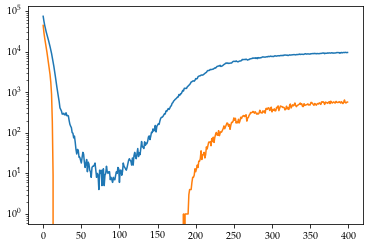

In [17]:
plt.semilogy(sparsity_train)
plt.semilogy(sparsity_test)
plt.show()

In [13]:
det_H = ch_real.cpu().detach().numpy() + ch_imag.cpu().detach().numpy() * 1j
true_H = channel_real_train.cpu().detach().numpy() + channel_imag_train.cpu().detach().numpy() * 1j
MSE = np.linalg.norm(det_H - true_H) ** 2 / np.linalg.norm(true_H) ** 2
print(MSE)

0.8748264397212272


In [170]:
print(ch_real.shape)

torch.Size([300, 64, 500])


In [3]:
H_f_train, H_a_train, activity_train = generate_batched_active_channel(params)
channel_real_train = torch.from_numpy(np.real(H_f_train)).squeeze().float().permute(0, 2, 1).cuda()
channel_imag_train = torch.from_numpy(np.imag(H_f_train)).squeeze().float().permute(0, 2, 1).cuda()
activity_train = torch.from_numpy(activity_train).float().cuda()

In [5]:
H_f_test, H_a_test, activity_test = generate_batched_active_channel(params)
channel_real_test = torch.from_numpy(np.real(H_f_test)).squeeze().float().permute(0, 2, 1).cuda()
channel_imag_test = torch.from_numpy(np.imag(H_f_test)).squeeze().float().permute(0, 2, 1).cuda()
activity_test = torch.from_numpy(activity_test).float().cuda()

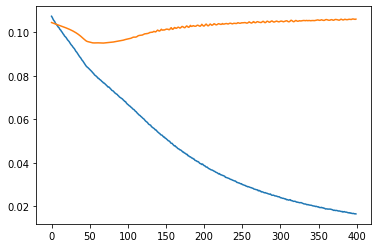

In [9]:
pilot = generate_random_pilot(50, params['K'], params['P'], params['simulations'])
y_train = pilot_through_channel(pilot, H_f_train, params['nvar'])
y_real_train = torch.from_numpy(np.real(y_train)).squeeze().float().cuda()
y_imag_train = torch.from_numpy(np.imag(y_train)).squeeze().float().cuda()
y_tensor_train = torch.cat((y_real_train, y_imag_train), dim=2)

pilot = generate_random_pilot(50, params['K'], params['P'], params['simulations'])
y_test = pilot_through_channel(pilot, H_f_test, params['nvar'])
y_real_test = torch.from_numpy(np.real(y_test)).squeeze().float().cuda()
y_imag_test = torch.from_numpy(np.imag(y_test)).squeeze().float().cuda()
y_tensor_test = torch.cat((y_real_test, y_imag_test), dim=2)

net = nn.LSTM(params['N_bs'] * 2, params['K'], num_layers=2, batch_first=True, dropout=0.5).cuda()
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=params['LR'])
losses_train = np.zeros((params['EPOCH']))
losses_test = np.zeros((params['EPOCH']))

for epoch in tqdm_notebook(range(params['EPOCH'])):
    net.train()
    out, hn = net(y_tensor_train)
    out = out[:, 49, :].squeeze()
    loss = loss_func(out, activity_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses_train[epoch] = loss.cpu().item()
    net.eval()
    out_test, hn = net(y_tensor_test)
    out_test = out_test[:, 49, :].squeeze()
    loss_test = loss_func(out_test, activity_test)
    losses_test[epoch] = loss_test.cpu().item()
plt.plot(losses_train)
plt.plot(losses_test)
plt.show()

In [7]:
print(out)

RuntimeError: cuda runtime error (710) : device-side assert triggered at ..\aten\src\THC\THCCachingHostAllocator.cpp:278

In [20]:
net = ActNet(params['N_bs'], params['K'], params['T']).cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=params['LR'], weight_decay=0.02)
loss_func = nn.BCELoss()
losses_train = np.zeros((params['EPOCH']))
losses_test = np.zeros((params['EPOCH']))
accuracy_train = np.zeros((params['EPOCH']))
accuracy_test = np.zeros((params['EPOCH']))
for epoch in tqdm_notebook(range(params['EPOCH'])):
    net.train()
    act = net(channel_real_train, channel_imag_train, params['nvar'])
    loss = loss_func(act, activity_train)
    losses_train[epoch] = loss.cpu().item() 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    act[act < 0.5] = 0
    act[act > 0.5] = 1
    accuracy_train[epoch] = (act == activity_train).float().mean().detach().cpu().item()
    net.eval()
    act_test = net(channel_real_test, channel_imag_test, params['nvar'])
    loss_test = loss_func(act_test, activity_test)
    losses_test[epoch] = loss_test.cpu().item()
    act_test[act_test < 0.5] = 0
    act_test[act_test > 0.5] = 1
    accuracy_test[epoch] = (act_test == activity_test).float().mean().detach().cpu().item()

NameError: name 'ActNet' is not defined

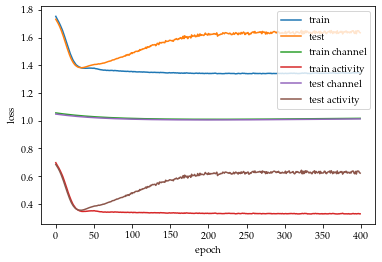

In [20]:
plt.plot(losses_train)
plt.plot(losses_test)
plt.plot(losses_ch_train)
plt.plot(losses_act_train)
plt.plot(losses_ch_test)
plt.plot(losses_act_test)
plt.legend(['train', 'test', 'train channel', 'train activity', 'test channel', 'test activity'])
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.savefig('plots/overfit.pdf')
plt.show()


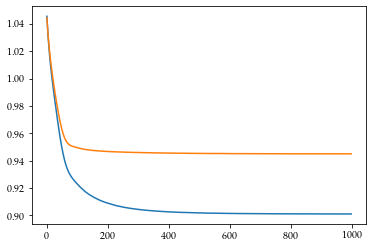

In [18]:
plt.plot(losses_ch_train)
plt.plot(losses_ch_test)
plt.show()

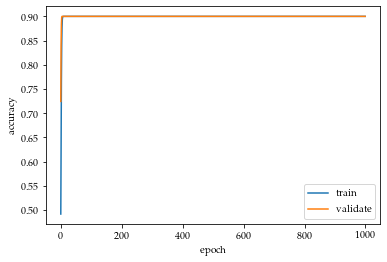

In [19]:
plt.plot(accuracy_train)
plt.plot(accuracy_test)
plt.legend(['train', 'validate'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [3]:
H_f_train, H_a_train, activity_train = generate_batched_active_channel(params)
pilot_train = generate_random_pilot(30, params['K'], params['P'], params['simulations'])
y_train = pilot_through_channel(pilot_train, H_f_train, params['nvar'])
pilot_train = np.linalg.pinv(pilot_train.squeeze())
P_train = totensor(pilot_train, cuda=True)
Y_train = totensor(y_train, cuda=True)
H_train = totensor(H_f_train, cuda=True)

In [20]:
import importlib
importlib.reload(DLutils)

NameError: name 'DLutils' is not defined

In [4]:
H_f_test, H_a_test, activity_test = generate_batched_active_channel(params)
pilot_test = generate_random_pilot(30, params['K'], params['P'], params['simulations'])
y_test = pilot_through_channel(pilot_test, H_f_test, params['nvar'])
pilot_test = np.linalg.pinv(pilot_test.squeeze())
P_test = totensor(pilot_train, cuda=True)
Y_test = totensor(y_train, cuda=True)
H_test = totensor(H_f_train, cuda=True)

In [5]:
net = SimpleResNet(params['N_bs'], 30, params['K']).cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=params['LR'])
loss_func = nn.MSELoss()
losses_train = np.zeros((params['EPOCH']))
losses_test = np.zeros((params['EPOCH']))
for epoch in tqdm_notebook(range(params['EPOCH'])):
    channel = net(Y_train, P_train)
    loss = loss_func(channel, H_train)
    losses_train[epoch] = loss.cpu().item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    channel_test = net(Y_test, P_test)
    loss_test = loss_func(channel_test, H_test)
    losses_test[epoch] = loss_test.cpu().item()

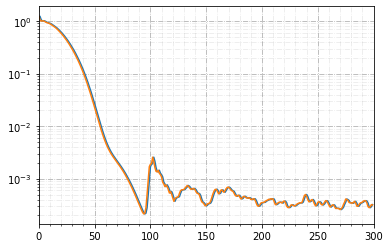

In [6]:
plt.semilogy(losses_train)
plt.semilogy(losses_test)
plt.xlim([0, 300])
plt.grid(which='major', linestyle='-.')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-.', alpha=0.2)

In [7]:
del P_train, Y_train, H_train, P_test, Y_test, H_test

In [9]:
Pe_n = np.zeros(params['Ka_set'].shape)
FA_n = np.zeros(params['Ka_set'].shape)
FM_n = np.zeros(params['Ka_set'].shape)
NMSE_n = np.zeros(params['Ka_set'].shape)

for i, Ka in enumerate(tqdm_notebook(params['Ka_set'])):
    params['Ka'] = Ka
    H_f, H_a, activity = generate_batched_active_channel(params)
    pilot = generate_random_pilot(30, params['K'], params['P'], params['simulations'])
    y = pilot_through_channel(pilot, H_f, params['nvar'])
    pilot = np.linalg.pinv(pilot.squeeze())
    P_test = totensor(pilot, cuda=True)
    Y_test = totensor(y, cuda=True)
    H_test = totensor(H_f, cuda=True)
    
    channel = net(Y_test, P_test)

    hf = toarray(channel, cuda=True)
    hf = np.expand_dims(hf, axis=3)
    act_ch = channel_aud(hf, params['N_bs'])
    Pe_n[i], FA_n[i], FM_n[i], NMSE_n[i] = performance(act_ch, activity, hf, H_f)

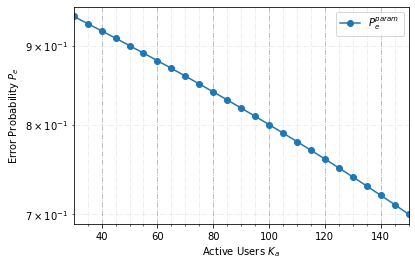

In [10]:
plt.semilogy(params['Ka_set'], Pe_n, '-o')
plt.xlim([30, 150])
plt.grid(True, linestyle='-.')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-.', alpha=0.2)
plt.legend(['$P_e^{param}$', '$P_e^{ch}$'])
plt.xlabel('Active Users $K_a$')
plt.ylabel('Error Probability $P_e$')
plt.savefig(fname='Probability_of_errorT30NN.pdf')
plt.show()

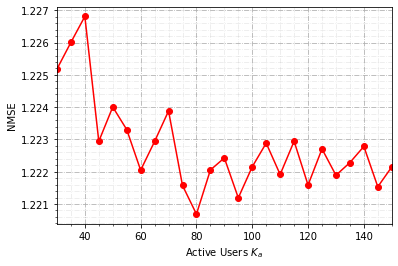

In [11]:
plt.plot(params['Ka_set'], NMSE_n, 'r-o')
plt.xlim([30, 150])
plt.grid(which='major', linestyle='-.')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-.', alpha=0.2)
plt.xlabel('Active Users $K_a$')
plt.ylabel('NMSE')
plt.savefig(fname='NMSET30NN.pdf')
plt.show()